In [134]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam

# Load the data
data = pd.read_csv("GOOGL.csv")

# Preprocessing
data['Date'] = pd.to_datetime(data['Date'])


seq_length = 25  # Length of input sequences

train_data = data[data['Date'] < '2021-01-01']
test_data = data[len(train_data)-seq_length:]

# Store the date column of the test data before scaling
test_dates = test_data['Date']

# print(train_data.head())

scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data.drop(columns=['Date']))
scaled_test_data = scaler.transform(test_data.drop(columns=['Date']))


# print(scaled_test_data[:5])

# Create sequences
def split_data(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


# Splitting correctly
X_train, y_train = split_data(scaled_train_data, seq_length)
X_test, y_test = split_data(scaled_test_data, seq_length)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [135]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # Define linear transformations
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hprev):
        # Reshape hprev to match the shape of inputs
        hprev = hprev.unsqueeze(1).expand(-1, inputs.size(1), -1)

        # Concatenate input and previous hidden state
        combined = torch.cat((inputs, hprev), dim=2)

        # Apply linear transformations
        hidden = torch.tanh(self.i2h(combined))
        output = self.i2o(hidden)

        return output, hidden

# Hyperparameters
input_size = X_train.shape[-1]
hidden_size = 64
output_size = y_train.shape[-1]
learning_rate = 0.0015
epochs = 100


# Initialize the model
model = RNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define regularization strength
l2_reg = 0.005

# Training loop

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs, _ = model(X_train_tensor, torch.zeros(X_train_tensor.size(0), hidden_size))  # Initial hidden state
    # Reshape outputs to match the shape of y_train_tensor
    outputs = outputs[:, -1, :]  # Take the last time step of the sequence
    loss = criterion(outputs, y_train_tensor)

    # Add L2 regularization
    l2_loss = 0
    for param in model.parameters():
        l2_loss += torch.norm(param)**2
    loss += l2_reg * l2_loss

    loss.backward()
    optimizer.step()

    '''if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')'''

# Testing
model.eval()
with torch.no_grad():
    test_outputs, _ = model(X_test_tensor, torch.zeros(X_test_tensor.size(0), hidden_size))
    test_outputs = test_outputs[:, -1, :]  # Take the last time step of the sequence
    test_loss = criterion(test_outputs, y_test_tensor)
    # print(f'Normalized values Test Loss: {test_loss.item():.6f}')


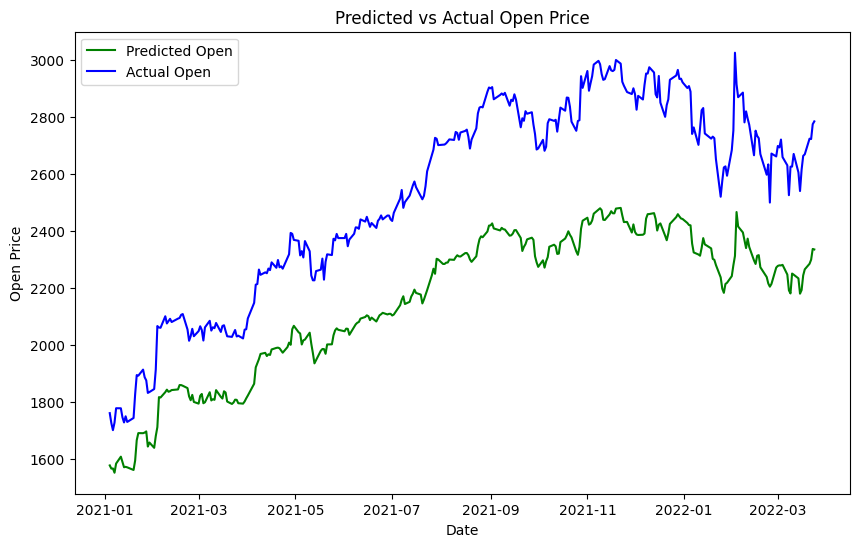

In [136]:
import matplotlib.pyplot as plt

# Inverse transform the predicted values to get the original scale
predicted_values = scaler.inverse_transform(test_outputs.numpy())

# print(predicted_values[:5])
# Add the stored date column back as the first column
predicted_df = pd.DataFrame(predicted_values[:, [0, 1, 2, 5]], columns=['Open', 'High', 'Low', 'Volume'])

predicted_df.insert(0, 'Date', test_data['Date'].values[seq_length:])

# Save the predicted values along with dates to a CSV file
predicted_df.to_csv('predicted_values.csv', index=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'][seq_length:], predicted_values[:, 0], label='Predicted Open', color='green')
plt.plot(test_data['Date'][seq_length:], test_data['Open'][seq_length:], label='Actual Open', color='blue')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Predicted vs Actual Open Price')
plt.legend()
plt.show()
